# Camera sticker app
AIFFEL 대전 탐색 노드 3   
간단한 카메라 스티커 앱을 만드는 프로젝트이다.openCV을 이용하여 이미지에 대해서 처리를 한다.   
프로세스는 다음과 같다.
0. Import package
1. Load data
2. Detect a face and landmarks
3. Check the sticker location
4. Apply the sticker
5. Other cases

## 0. Import package

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

## 1. Load data
사용할 이미지를 가져오기

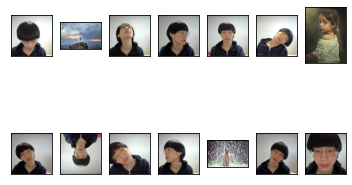

In [2]:
# 여러 개의 이미지를 한 번에 출력
fig = plt.figure() 
rows = 2
cols = 7
i = 1
 
y_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/*.jpg'
file_list = []

# 모든 이미지
for filename in glob.glob(y_image_path):
    file_list.append(filename)
    img = cv2.imread(filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
plt.show()

### 1-1 Sample
openCV에서는 이미지 처리방식이 RGB가 아닌 BGR이다.

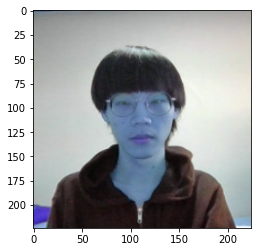

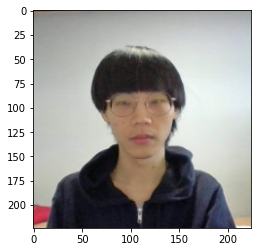

In [3]:
# 적용해 볼 이미지 가져오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/6.jpg'

img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서 color bgr 순서
img_bgr = cv2.resize(img_bgr, (224, 224))    # Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr 순서를 rgb 순서로 변경
plt.imshow(img_rgb)
plt.show()

## 2. Detect a face and landmarks
패키지와 미리 정의되어 있는 랜드마크를 이용한다.

### 2-1 Detect a face

rectangles[[(71, 80) (146, 155)]]


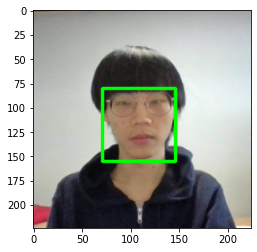

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

# 얼굴 표시하기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2-2 Detect landmarks

In [5]:
# 미리 정의된 랜드마크 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


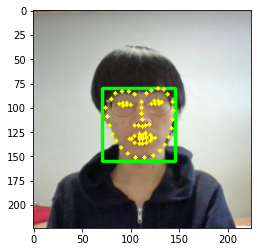

In [6]:
# 랜드마크 표시
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. Check the sticker loaction

### 3-1 Set location

In [7]:
# 합성할 이미지의 기준점 세팅
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose tip index : 33
    x = landmark[33][0]
    y = landmark[33][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(112, 119)
(x,y) : (112,119)
(w,h) : (76,76)


In [8]:
# 합성할 이미지 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/stick/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(76, 76, 3)


In [9]:
# 합성할 이미지 위치 정하기
refined_x = x - w // 2  # left
refined_y = y - h // 2      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (74,81)


In [10]:
# 합성할 이미지가 벗어나는 경우 처리
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    print (img_sticker.shape)

    refined_y = 0
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
else:
    print('ok')

ok


### 3-2 Check the location

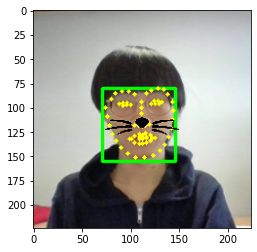

In [11]:
# 이미지 합성하기 (테스트)
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 4. Apply the sticker

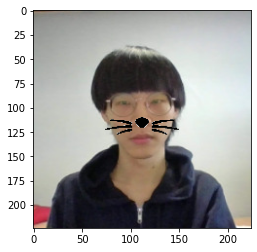

In [12]:
# 이미지 합성하기
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5. Other cases
위에 정면 이미지를 포함하여 여러 케이스를 적용해보고 비교 분석한다.

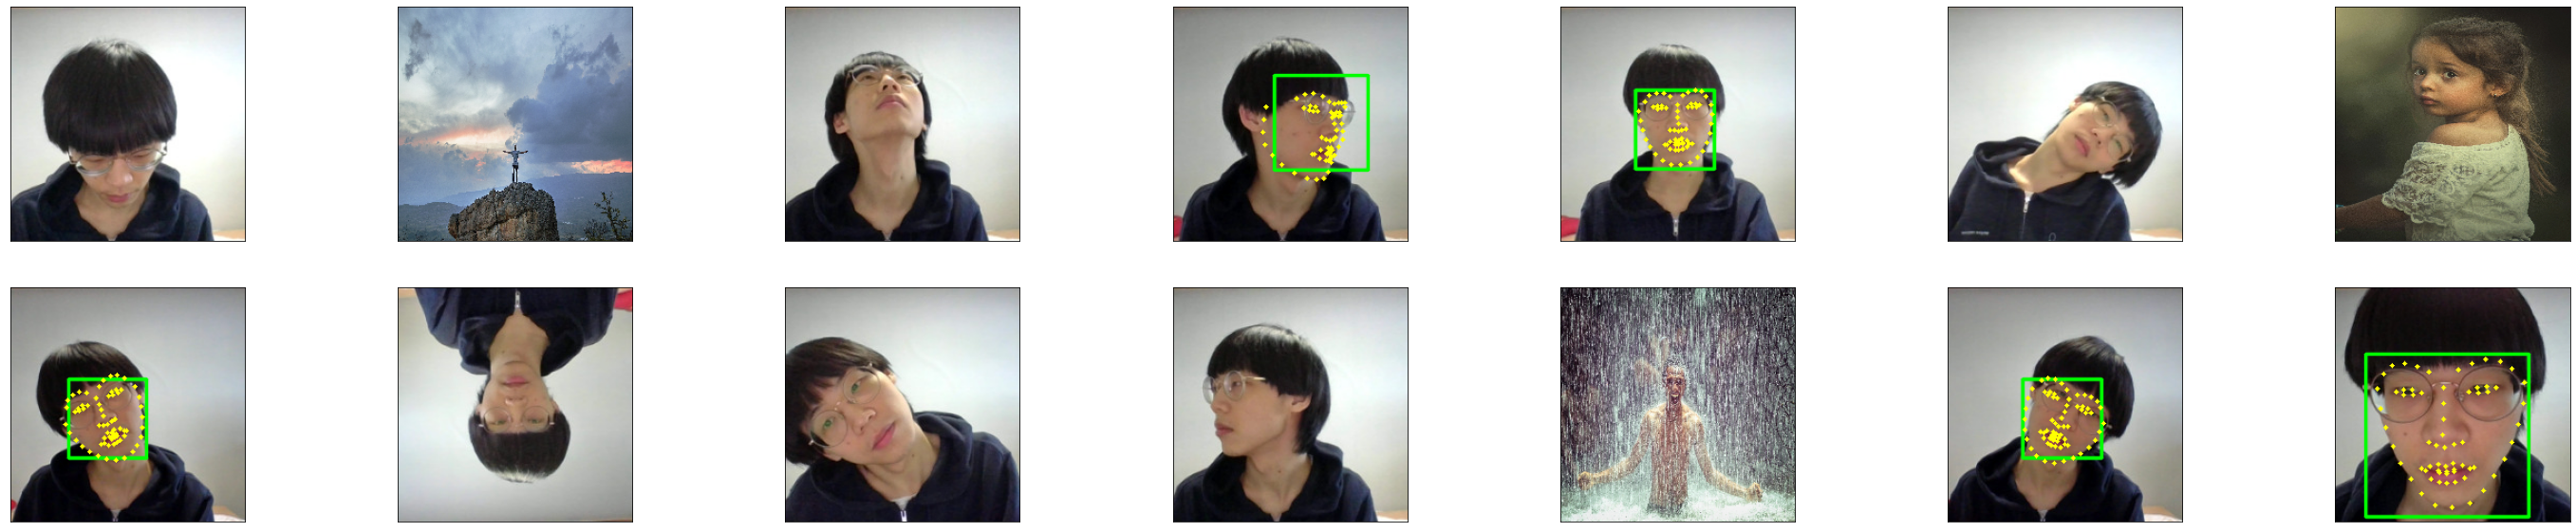

In [13]:
# 위에 코드를 합친 것으로 여러 케이스에 대하여 얼굴 인식 및 랜드마크를 보여준다.
fig = plt.figure(figsize =(50,10)) 

rows = 2
cols = 7
i = 1
for filename in file_list:
    img_bgr = cv2.imread(filename)
    img_bgr = cv2.resize(img_bgr, (224, 224))    # Resize
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr 순서를 rgb 순서로 변경
    img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

    detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
    dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
    if len(dlib_rects) == 0:
        pass
    else:
        for dlib_rect in dlib_rects:
            l = dlib_rect.left()
            t = dlib_rect.top()
            r = dlib_rect.right()
            b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
        
        # 미리 정의된 랜드마크 불러오기
        model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
        landmark_predictor = dlib.shape_predictor(model_path)

        list_landmarks = []
        for dlib_rect in dlib_rects:
            points = landmark_predictor(img_rgb, dlib_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)
        # 랜드마크 표시
        for landmark in list_landmarks:
            for idx, point in enumerate(list_points):
                cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
plt.show()

### 보고서
- 얼굴각도   
처음 이미지(1,5)인 정면을 기준으로 앞뒤로 기울이기{(1,1),(1,3)}, 옆으로 기울이기{(1,6),(2,1),(2,3),(2,6)}, 얼굴 옆으로 돌리기{(1,4),(1,7),(2,4)}, 뒤집기(2,2) 등으로 얼굴 인식을 적용해 보았다.   
결과는 정면은 당연히 잘 인식했고, 앞 뒤로 기울이기, 뒤집기는 인식하지 못했다. 옆으로 기울이기와 얼굴 옆으로 돌리기는 돌린 정도에 따라 인식을 할 수도 못 할 수도 있었다. 종합해보면 정면에서 크게 벗어나지 않아야 인식을 할 수 있다는 것이다. get_frontal_face_detector() 함수 이름에도 알 수 있듯이 정면 얼굴에 적용해야 함을 유추할 수 있다. 만약 약간의 얼굴 각도가 변경되는 경우에는 이미지에서 기준점들도 정면과 달라지기 때문에 한 점이 아닌 여러 점을 이용해서 얼굴이 정면에서 벗어난 각도를 계산하고 그에 맞는 스티커의 위치를 정해야 한다.(정사영, 회전이 필요할 수도 있다.)
- 촬영거리   
촬영거리가 멀고 가깝다는 것은 결국 얼굴의 크기가 작아지고 커진다는 것을 의미한다. 따라서 얼굴 크기 순으로 비교를 해보면(모두 정면)(1,2), (2,5), (1,5), (2,7) 순으로 커진다. 결과를 보면 (1,5)부터 인식을 하는 것을 알 수 있다. (2,5)의 경우 장애물이 있어 보이지만 사람이 보기에 얼굴을 인식하는데는 문제가 없다. (1,2)는 너무 멀어서 사람도 얼굴을 인식하기 어렵다. 즉, 어느 정도 가까워야 인식을 할 수 있는 것을 보여준다.
- 실행속도 중요성   
실행속도는 사용자의 편의성과 연결이 된다. 따라서 매우 중요한 것 중에 하나이다. 지금은 간단히 테스트를 위해서 많은 데이터에 대해서 적용하지 않았지만 많은 데이터를 한 번에 처리를 하려면 시간이 오래 걸릴 수도 있다. 앱을 사용할 때에 실행속도가 많이 중요하다면 이미지를 작게 만들어서 처리 시간을 줄이는 것도 방법이 될 수 있다.
- 정확도 중요성   
만약 스티커의 위치가 이상한 곳에 있으면 이 앱을 사용하는 의미자체가 사라질 것이다. 따라서 정확히 위치를 찾아내는 것이 매우 중요하다. 같은 정면이라도 약간의 각도의 변화가 있을 때에 스티커 역시 정면이 아닌 변화를 주어야 한다. 그러기 위해서는 공간(선형대수학)에 대해서 잘 이해하고 계산하는 것이 중요하다.

## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. 자기만의 카메라앱 기능 구현을 완수하였다.(원본에 스티커 사진이 정상적으로 합성되었다.)	
    
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.(정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.)

3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.(얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.)

### 평가 항목에 대한 수행
1. 순서대로 프로세스를 따라가보면 스티커를 원본에 정상적으로 합성된 것을 확인할 수 있다.
2. 코에 끝에 위치를 이용하여 좌표 계산을 통해 고양이 수염 스티커를 원본에 붙여서 잘 어울리게 출력하였다.
3. 마지막 other cases에서 다양한 경우에 적용했을 때 문제점을, 얼굴각도, 촬영거리 등을 이용하여 분석하였다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
어려웠던 점은 들어보기만 한 openCV를 처음 써봐서, 익숙하지 않았다. 그리고 노드에서 낚시를 할거라고 생각도 못했는데, 낚시가 있어서 힘들었다. 그리고 일부러 그렇게 한 지는 모르겠으나 예제 케이스가 원본이미지에서 스티커 일부가 벗어나는데 그 예외처리를 하기 위한 코드만 있어서 정작 스티커 이미지가 잘 들어가면 동작이 안되도록 예제 코드를 주어서 불편했다. 그리고 낚시에 경우는 우선 스티커 위치를 찾는데 굳이 어렵게 '볼'을 추천하여 잠깐 헷갈렸다. 그냥 양쪽 볼 사이인 코를 기준으로 하면 더 쉽게 처리할 수 있다. 또 다른 하나는 openCV 함수 addWeighted 낚시였다. 몰라서 openCV 레퍼런스를 뒤져가며 알아보니 같은 사이즈에만 결합할 수 있는 함수였다. 당연히 스티커가 원본 이미지보다 작을텐데... 할 말을 잃고 그냥 다른 함수를 이용해서 처리했다. 결국 정리해보면 노드에 낚시에 걸렸고, openCV를 처음 써서 레퍼런스를 많이 참고해야 했다.
---
- **알아낸 점**    
함수 레퍼런스를 이용해 함수 사용법에 대해서 알 수 있었다. 그 중 가장 좋았던 것이 np.where()로 C언어에서 삼항연산자와 거의 동일한 기능과 형식을 갖추고 있었다는 점이다. 아마 numpy가 C 언어 베이스라서 그런 것 같다. 그리고 위에서 사용한 얼굴 인식 함수는 정말 정면에 가까운 것만 인식할 수 있다는 점에서 성능이 그렇게 좋은 것 같진 않다. 그리고 openCV 이미지 처리는 RGB 순서가 아닌 BGR 순서라는 것이다.

- **모호한 점**    
얼굴 인식이나, 랜드마크 표시하는 것 모두 있는 것을 활용하여 구현을 해서 내부 원리에 대해서는 정확히 파악하지 못하고 있다. 다만, 노드에서 언급한 gradient를 이용했다고만 추측할 뿐이다.
---
- **시도한 것들**    
데이터를 얻기 위해서 다음 출처를 사용했다. https://teachablemachine.withgoogle.com/train/image, https://pixabay.com/ko/ 
그리고 스티커의 정확한 위치를 찾기 위에서 코 끝의 위치(기준점)를 이용하였고 스티커의 코 위치와 기준점이 대응될 수 있도록 스티커의 중앙이 코 위치가 되도록 하였다. 또한 스티커의 배경으로 원본이미지가 덮이는 현상이 있었는데 np.where의 조건을 변경하므로써 해결하였다. 사실 이런 저런 시도가 조금 있었다.   

---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
처음에 노드 예제를 할 때에 예제에서 가정하는 이미지와 실제로 사용한 이미지가 달라서 처음 오류가 났을 때 당황을 해서 시간을 많이 소비했다. 그리고 노드에서 추천한 힌트 중에 좋은 힌트는 내가 봤을 때 없었던 것 같다. 덕분에 openCV 함수들에 대해서 많이 알아볼 수 있었다. 사실 얼굴 사진 찍는 것에 관심이 없어서 그다지 흥미가 있진 않았다. 얼굴 인식과 랜드마크를 처리하는 부분도 블랙박스로 남겨둔 채로 진행한 프로젝트라서 좀 아쉬운 것 같다. 물론 이미지를 처리한다는 것 자체가 의미가 있는 것이지만 결국 이것 역시 처음부터 짜는 것이 아닌 미리 정의된 함수를 사용하는 것이라 나한테는 함수의 사용법을 배우는 정도였던 것 같다. 아 그리고 코드에 주석을 한글로 처리했는데 예전 것은 예제 코드가 아니면 영어를 쓸려고 노력을 했다. 그런데 문법이나 단어의 뜻이 맞는지 확인하는데 좀 시간이 걸려서 빠르게 하기 위해서 바로 생각이나는 한글을 이용해 주석을 달았다. 그래도 프로세스의 제목은 영어로 유지하였다. 다음 프로젝트는 딥러닝 모델을 자세히 쓸 수 있는 것이였으면 좋겠다.   
이렇게 내 얼굴을 인터넷에 공개하게 돼서 조금 부끄럽다.